In [1]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
import sys
print(sys.version)

3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]


In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2636890073072265258
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3655335936
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15534695236850298151
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [6]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [6]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [ ]:
# http://vis-www.cs.umass.edu/lfw/

In [ ]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [8]:
# Import uuid library to generate unique image names
import uuid

In [9]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\10ffe9e9-7520-11ee-a344-b48c9d5ca367.jpg'

In [10]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

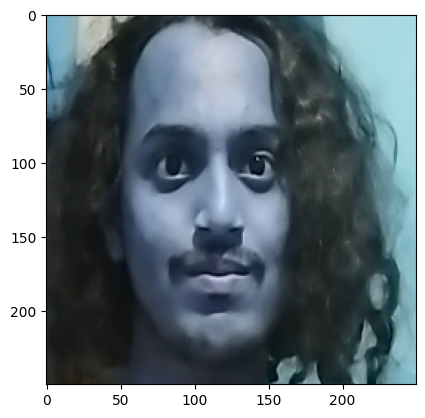

In [11]:
plt.imshow(frame)

In [12]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [13]:
import os
import uuid

In [14]:
img_path = os.path.join(ANC_PATH, '456537fb-7508-11ee-aab7-b48c9d5ca367.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [ ]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(800)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(800)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(800)

In [ ]:
dir_test = anchor.as_numpy_iterator()

In [ ]:
print(dir_test.next())

In [181]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [192]:
img = preprocess('data\\anchor\\456537fb-7508-11ee-aab7-b48c9d5ca367.jpg')

In [193]:
img.numpy().max() 

1.0

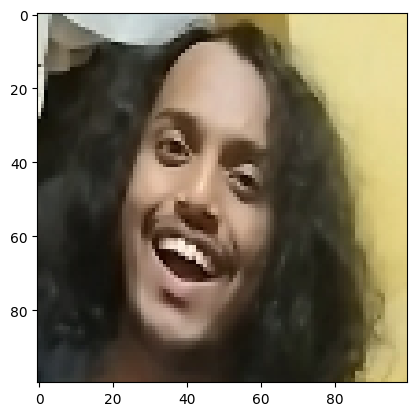

In [194]:
plt.imshow(img)

In [198]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [208]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [239]:
samples = data.as_numpy_iterator()

In [240]:
exampple = samples.next()

In [241]:
exampple

(b'data\\anchor\\42dc7408-7508-11ee-9cdc-b48c9d5ca367.jpg',
 b'data\\positive\\3d010e9e-7509-11ee-b167-b48c9d5ca367.jpg',
 1.0)

In [242]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [243]:
res = preprocess_twin(*exampple)

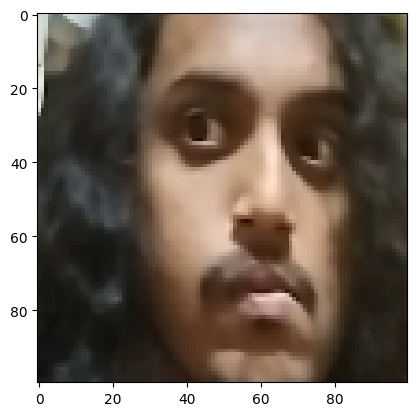

In [244]:
plt.imshow(res[1])

In [245]:
res[2]

1.0

In [246]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [247]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [248]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [249]:
inp = Input(shape=(100,100,3), name='input_image')

In [250]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [251]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [252]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [253]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [254]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [255]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [257]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 17, 17, 128)       26

In [258]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [259]:
embedding = make_embedding()

In [260]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 17, 17, 128)       26

In [261]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [262]:
l1 = L1Dist()

In [264]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [265]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [266]:
siamese_layer = L1Dist()

In [267]:
distances = siamese_layer(inp_embedding, val_embedding)

In [268]:
classifier = Dense(1, activation='sigmoid')(distances)

In [269]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_6')>

In [270]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [271]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [272]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [273]:
siamese_model = make_siamese_model()

In [274]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [275]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [276]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [277]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [278]:
test_batch = train_data.as_numpy_iterator()

In [279]:
batch_1 = test_batch.next()

In [280]:
X = batch_1[:2]

In [281]:
y = batch_1[2]

In [282]:
y

array([0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
      dtype=float32)

In [284]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [285]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [286]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [287]:
EPOCHS = 50

In [288]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
70/70 [==============================] - 28s 395ms/step
0.28920057 0.6816609 0.94711536

 Epoch 2/50
70/70 [==============================] - 27s 393ms/step
0.16225818 0.925859 0.9789675

 Epoch 3/50
70/70 [==============================] - 28s 401ms/step
0.0920136 0.9380531 0.98513013

 Epoch 4/50
70/70 [==============================] - 28s 406ms/step
0.06467592 0.96478873 0.99636364

 Epoch 5/50
70/70 [==============================] - 29s 409ms/step
0.005780072 0.96106195 0.9926874

 Epoch 6/50
70/70 [==============================] - 29s 413ms/step
0.0050926134 0.9927798 1.0

 Epoch 7/50
70/70 [==============================] - 29s 417ms/step
0.01962746 0.9910873 0.9964158

 Epoch 8/50
70/70 [==============================] - 29s 416ms/step
0.12785754 0.99820465 1.0

 Epoch 9/50
70/70 [==============================]

In [301]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [325]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [326]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 23ms/step


In [327]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]

In [328]:
y_true

array([0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1.],
      dtype=float32)

In [329]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [330]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [331]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 17ms/step
1.0 1.0


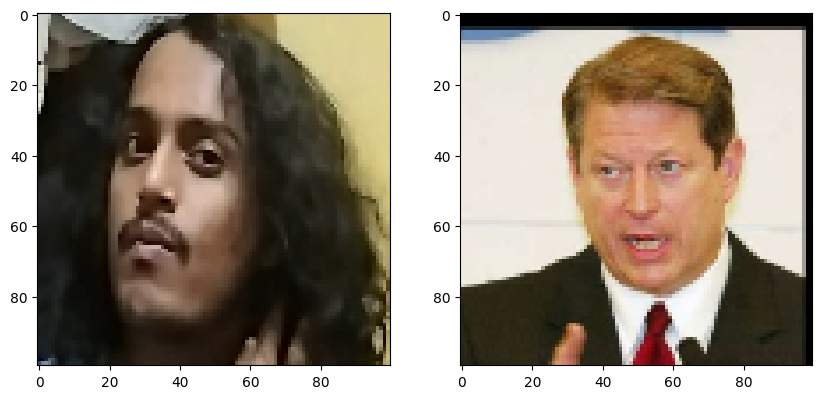

In [336]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [337]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [338]:
L1Dist

__main__.L1Dist

In [339]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [340]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 0s 78ms/step


array([[1.4966059e-08],
       [1.5451833e-07],
       [6.9397049e-07],
       [7.0867642e-08],
       [1.0000000e+00],
       [1.2796554e-09],
       [4.1978995e-10],
       [4.3497703e-08],
       [9.9977785e-01],
       [9.9943298e-01],
       [9.9999988e-01],
       [1.0000000e+00],
       [8.6219373e-08],
       [4.9776850e-07],
       [1.0000000e+00],
       [7.8572508e-09]], dtype=float32)

In [341]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [343]:
os.listdir(os.path.join('application_data', 'verification_images'))

['02f29f50-7509-11ee-bb88-b48c9d5ca367 - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy (2).jpg',
 '1ae7a3da-7509-11ee-91ec-b48c9d5ca367 - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy (2).jpg',
 '1e358f6b-7509-11ee-942f-b48c9d5ca367 - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy (2).jpg',
 '2627a714-7509-11ee-a9ca-b48c9d5ca367 - Copy - Copy - Copy - Copy (2).jpg',
 '2cb9af4c-7509-11ee-b1c0-b48c9d5ca367 - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy (2).jpg',
 '2dece37c-7509-11ee-8793-b48c9d5ca367 - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy (2).jpg',
 '2f375daa-7509-11ee-8ddc-b48c9d5ca367 - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy (2).jpg',
 '336165a9-750a-11ee-b7da-b48c9d5ca367 - Copy - Copy (2).jpg',
 '3435bbea-750a-11ee-b78e-b48c9d5ca367 - Copy - Copy - Copy - Copy - Copy (2).jpg',
 '3459a5fb-750a-11ee

In [344]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [345]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\02f29f50-7509-11ee-bb88-b48c9d5ca367 - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy (2).jpg
application_data\verification_images\1ae7a3da-7509-11ee-91ec-b48c9d5ca367 - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy (2).jpg
application_data\verification_images\1e358f6b-7509-11ee-942f-b48c9d5ca367 - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy (2).jpg
application_data\verification_images\2627a714-7509-11ee-a9ca-b48c9d5ca367 - Copy - Copy - Copy - Copy (2).jpg
application_data\verification_images\2cb9af4c-7509-11ee-b1c0-b48c9d5ca367 - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy (2).jpg
application_data\verification_images\2dece37c-7509-11ee-8793-b48c9d5ca367 - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy - Copy (2).jpg
application_data\verification_images\2f375daa-7509-11ee-8ddc-b48c9d5ca367 - Copy - Copy - Copy 

In [346]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [355]:
results

[array([[0.9998549]], dtype=float32),
 array([[0.91925263]], dtype=float32),
 array([[0.99999857]], dtype=float32),
 array([[0.9999503]], dtype=float32),
 array([[0.99999917]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.99999976]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.99929297]], dtype=float32),
 array([[0.99999917]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9999999]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9962921]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9999999]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.9999999